# 08 Interactive Dashboard

交互式综合仪表盘，支持样本选择、模型切换、参数调整等交互功能。

In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt

from utils.data_loader import load_predictions, load_dataset, get_time_array
from utils.visualizer import plot_damage_comparison
from utils.config import LATEST_PREDICTIONS, DATASET_PATH, DT

In [2]:
# 尝试导入 ipywidgets
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    HAS_IPYWIDGETS = True
    print("ipywidgets 已加载")
except ImportError:
    HAS_IPYWIDGETS = False
    print("ipywidgets 未安装，将使用静态展示")

ipywidgets 已加载


## 加载数据

In [3]:
# 加载预测结果
y_true, y_pred = load_predictions(LATEST_PREDICTIONS)

# 加载原始数据
data = load_dataset(DATASET_PATH, normalize=False)

print(f"样本数: {y_true.shape[0]}")
print(f"单元数: {y_true.shape[1]}")
print(f"时间步数: {data['disp'].shape[1]}")

样本数: 3000
单元数: 11
时间步数: 201


## 静态展示 (无需 ipywidgets)

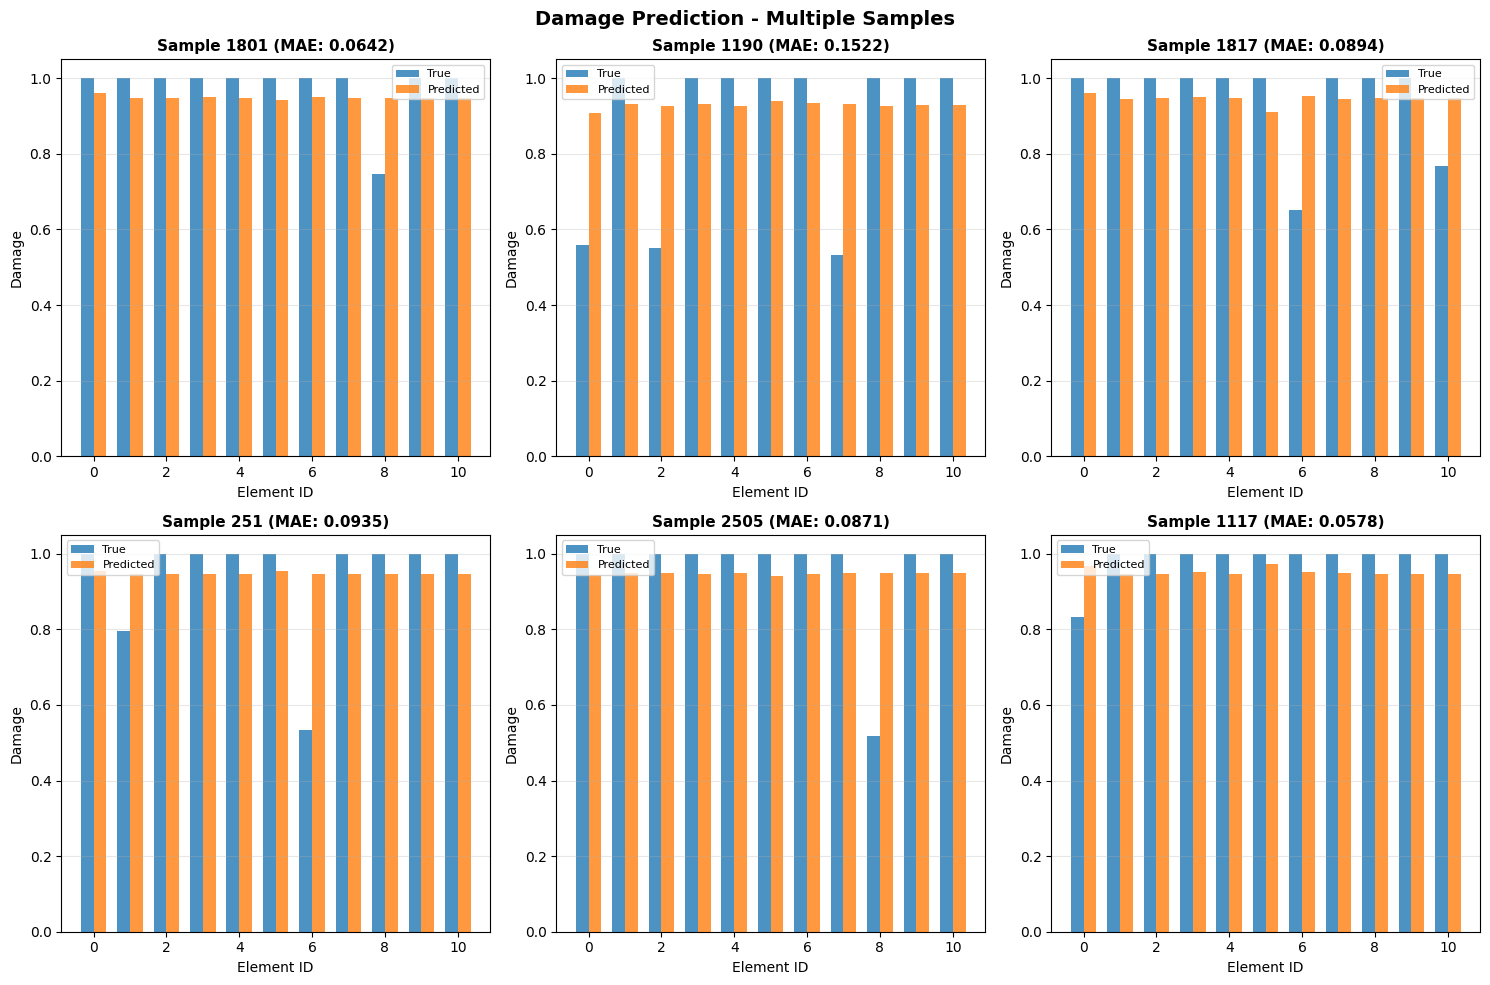

In [4]:
# 静态展示 - 选择多个样本
np.random.seed(42)
n_show = 6
sample_indices = np.random.choice(y_true.shape[0], n_show, replace=False)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, s_idx in enumerate(sample_indices):
    x = np.arange(len(y_true[s_idx]))
    
    # 绘制对比柱状图
    width = 0.35
    axes[idx].bar(x - width/2, y_true[s_idx], width, label='True', alpha=0.8)
    axes[idx].bar(x + width/2, y_pred[s_idx], width, label='Predicted', alpha=0.8)
    
    # 计算误差
    mae = np.mean(np.abs(y_true[s_idx] - y_pred[s_idx]))
    
    axes[idx].set_xlabel('Element ID', fontsize=10)
    axes[idx].set_ylabel('Damage', fontsize=10)
    axes[idx].set_title(f'Sample {s_idx} (MAE: {mae:.4f})', fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=8)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.suptitle('Damage Prediction - Multiple Samples', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 交互式展示 (需要 ipywidgets)

In [ ]:
if HAS_IPYWIDGETS:
    # 创建交互式组件
    
    # 样本索引选择器
    sample_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=y_true.shape[0] - 1,
        step=1,
        description='Sample Index:',
        continuous_update=False
    )
    
    # 位移放大系数选择器
    scale_slider = widgets.FloatSlider(
        value=50.0,
        min=0.0,
        max=200.0,
        step=10.0,
        description='Scale Factor:',
        continuous_update=False
    )
    
    # 时间步选择器
    time_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=data['disp'].shape[1] - 1,
        step=1,
        description='Time Step:',
        continuous_update=False
    )
    
    # 输出区域
    output = widgets.Output()
    
    def update_dashboard(change=None):
        """更新仪表盘"""
        sample_idx = sample_slider.value
        time_idx = time_slider.value
        scale = scale_slider.value
        
        with output:
            clear_output(wait=True)
            
            fig, axes = plt.subplots(1, 3, figsize=(15, 4))
            
            # 1. 损伤对比
            x = np.arange(len(y_true[sample_idx]))
            axes[0].bar(x - 0.2, y_true[sample_idx], 0.4, label='True')
            axes[0].bar(x + 0.2, y_pred[sample_idx], 0.4, label='Predicted')
            axes[0].set_xlabel('Element ID')
            axes[0].set_ylabel('Damage')
            axes[0].set_title(f'Damage - Sample {sample_idx}')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 2. 位移响应
            t = get_time_array(data['disp'].shape[1], DT)
            dof_to_show = 2  # 某个自由度
            axes[1].plot(t, data['disp'][sample_idx, :, dof_to_show])
            axes[1].axvline(x=t[time_idx], color='r', linestyle='--', alpha=0.7)
            axes[1].set_xlabel('Time (s)')
            axes[1].set_ylabel('Displacement (m)')
            axes[1].set_title(f'Displacement Response - DOF {dof_to_show}')
            axes[1].grid(True, alpha=0.3)
            
            # 3. 应力时程
            elem_to_show = len(y_true[sample_idx]) // 2
            axes[2].plot(t, data['stress'][sample_idx, :, elem_to_show])
            axes[2].axvline(x=t[time_idx], color='r', linestyle='--', alpha=0.7)
            axes[2].set_xlabel('Time (s)')
            axes[2].set_ylabel('Stress (Pa)')
            axes[2].set_title(f'Stress - Element {elem_to_show}')
            axes[2].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
    
    # 绑定事件
    sample_slider.observe(update_dashboard, names='value')
    time_slider.observe(update_dashboard, names='value')
    scale_slider.observe(update_dashboard, names='value')
    
    # 初始化显示
    update_dashboard()
    
    # 布局
    dashboard = widgets.VBox([
        widgets.HTML('<h2>Interactive Damage Prediction Dashboard</h2>'),
        sample_slider,
        time_slider,
        scale_slider,
        output
    ])
    
    display(dashboard)
else:
    print("请安装 ipywidgets 以使用交互功能:")
    print("pip install ipywidgets")
    print("jupyter nbextension enable --py widgetsnbextension")

## 数据统计面板

In [6]:
# 统计摘要
print("=" * 60)
print("数据统计摘要")
print("=" * 60)

print(f"\n【数据集】")
print(f"  总样本数: {y_true.shape[0]}")
print(f"  单元数: {y_true.shape[1]}")
print(f"  时间步数: {data['disp'].shape[1]}")

print(f"\n【损伤分布】")
print(f"  真实值范围: [{y_true.min():.4f}, {y_true.max():.4f}]")
print(f"  预测值范围: [{y_pred.min():.4f}, {y_pred.max():.4f}]")
print(f"  真实值均值: {y_true.mean():.4f}")
print(f"  预测值均值: {y_pred.mean():.4f}")

print(f"\n【误差统计】")
errors = y_true - y_pred
abs_errors = np.abs(errors)
print(f"  MAE: {abs_errors.mean():.4f}")
print(f"  RMSE: {np.sqrt((errors**2).mean()):.4f}")
print(f"  Max Error: {abs_errors.max():.4f}")

数据统计摘要

【数据集】
  总样本数: 3000
  单元数: 11
  时间步数: 201

【损伤分布】
  真实值范围: [0.5002, 1.0000]
  预测值范围: [0.6001, 0.9922]
  真实值均值: 0.9456
  预测值均值: 0.9462

【误差统计】
  MAE: 0.0869
  RMSE: 0.1239
  Max Error: 0.4633
